In [ ]:
# This is a notebook, where all the methods are collected, once tested, I stored them in the python scripts 'evaluation.py' and 'unsupervised_methods.py'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import csv
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from sklearn import linear_model
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from operator import itemgetter
from itertools import groupby

In [2]:
datafile = '/data/project/general/aerosolretriev/Jungfraujoch_data/data/aerosol_data.h5'



In [3]:
df = pd.read_hdf(datafile, 'df') 

In [4]:
# restrict the data set to the time that start with the beginning of the first sde event and ends with end of the last sde event
first_event_index = df['sde_event'].idxmax()
last_event_index = df['sde_event'].where(df['sde_event']==1).last_valid_index()
df_new = df.loc[first_event_index:last_event_index]
df_new

DateTimeUTC  N_N11  BsB_S12  BsG_S12  BsR_S12  \
2020-02-08 14:00:00 2020-02-08 14:00:00  516.0     1.74     1.20     0.78   
2020-02-08 15:00:00 2020-02-08 15:00:00  465.0     1.66     0.99     0.44   
2020-02-08 16:00:00 2020-02-08 16:00:00  401.0     2.08     1.80     1.83   
2020-02-08 17:00:00 2020-02-08 17:00:00  411.0     1.18     0.77     0.57   
2020-02-08 18:00:00 2020-02-08 18:00:00  452.0     1.27     1.17     0.76   
...                                 ...    ...      ...      ...      ...   
2020-11-24 23:00:00 2020-11-24 23:00:00  349.0     1.08     0.98     0.90   
2020-11-25 00:00:00 2020-11-25 00:00:00  355.0     0.99     0.98     0.78   
2020-11-25 01:00:00 2020-11-25 01:00:00  347.0     1.53     1.25     0.48   
2020-11-25 02:00:00 2020-11-25 02:00:00  312.0     1.26     0.97     0.55   
2020-11-25 03:00:00 2020-11-25 03:00:00  300.0     1.03     1.05     0.55   

                     BbsB_S12  BbsG_S12  BbsR_S12  BaCorr2_A13  BaCorr3_A13  \
2020-02-08 14:00:00      0.55      0.10      0.07         0.28         0.25   
2020-02-08 15:00:00      0.29      0.19      0.10         0.25         0.23   
2020-02-08 16:00:00      0.11      0.06      0.46         0.28         0.24   
2020-02-08 17:00:00      0.48     -0.10      0.12         0.30         0.25   
2020-02-08 18:00:00      0.17      0.01      0.14         0.40         0.35   
...                       ...       ...       ...          ...          ...   
2020-11-24 23:00:00      0.18      0.08      0.31         0.11         0.09   
2020-11-25 00:00:00      0.02      0.19      0.18         0.11         0.09   
2020-11-25 01:00:00      0.04     -0.09     -0.02         0.10         0.08   
2020-11-25 02:00:00      0.18     -0.07      0.02         0.10         0.09   
2020-11-25 03:00:00      0.21      0.06      0.22         0.12         0.09   

                     ...  V_D15_973718  V_D17_165483  V_D18_446161  \
2020-02-08 14:00:00  ...     29.080796      1.850277      6.818125   
2020-02-08 15:00:00  ...     16.924910      1.850277      6.818125   
2020-02-08 16:00:00  ...     11.211188     94.011016      0.000000   
2020-02-08 17:00:00  ...      0.000000      3.714678     13.636249   
2020-02-08 18:00:00  ...      0.000000      0.000000      0.000000   
...                  ...           ...           ...           ...   
2020-11-24 23:00:00  ...      0.000000      0.000000      0.000000   
2020-11-25 00:00:00  ...      0.000000      0.000000      0.000000   
2020-11-25 01:00:00  ...      0.000000      0.000000      0.000000   
2020-11-25 02:00:00  ...      0.000000      0.000000      0.000000   
2020-11-25 03:00:00  ...      0.000000      0.000000      0.000000   

                     V_D19_822390  V_D21_301296  V_D22_890539  V_D24_598352  \
2020-02-08 14:00:00      9.091629     12.118860     16.177542     21.571619   
2020-02-08 15:00:00      9.091629     12.118860     16.177542     21.571619   
2020-02-08 16:00:00      0.000000      0.000000      0.000000      0.000000   
2020-02-08 17:00:00     18.183257     24.264711     32.355084     43.143238   
2020-02-08 18:00:00      0.000000      0.000000      0.000000      0.000000   
...                           ...           ...           ...           ...   
2020-11-24 23:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 00:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 01:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 02:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 03:00:00      0.000000      0.000000      0.000000      0.000000   

                     V_D26_433582  sde_event  sde_event_nr  
2020-02-08 14:00:00      7.839872        1.0           1.0  
2020-02-08 15:00:00      7.839872        1.0           1.0  
2020-02-08 16:00:00      0.000000        1.0           1.0  
2020-02-08 17:00:00     15.628167        1.0           1.0  
2020-02-08 18:00:00      0.000000        1.0           1.0 

In [5]:
#df1 = df_new[df_new.columns[1:23]]
# delete the first column with the DateTime
df1 = df_new[df_new.columns[1:]]
df1

N_N11  BsB_S12  BsG_S12  BsR_S12  BbsB_S12  BbsG_S12  \
2020-02-08 14:00:00  516.0     1.74     1.20     0.78      0.55      0.10   
2020-02-08 15:00:00  465.0     1.66     0.99     0.44      0.29      0.19   
2020-02-08 16:00:00  401.0     2.08     1.80     1.83      0.11      0.06   
2020-02-08 17:00:00  411.0     1.18     0.77     0.57      0.48     -0.10   
2020-02-08 18:00:00  452.0     1.27     1.17     0.76      0.17      0.01   
...                    ...      ...      ...      ...       ...       ...   
2020-11-24 23:00:00  349.0     1.08     0.98     0.90      0.18      0.08   
2020-11-25 00:00:00  355.0     0.99     0.98     0.78      0.02      0.19   
2020-11-25 01:00:00  347.0     1.53     1.25     0.48      0.04     -0.09   
2020-11-25 02:00:00  312.0     1.26     0.97     0.55      0.18     -0.07   
2020-11-25 03:00:00  300.0     1.03     1.05     0.55      0.21      0.06   

                     BbsR_S12  BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  ...  \
2020-02-08 14:00:00      0.07         0.28         0.25         0.21  ...   
2020-02-08 15:00:00      0.10         0.25         0.23         0.20  ...   
2020-02-08 16:00:00      0.46         0.28         0.24         0.19  ...   
2020-02-08 17:00:00      0.12         0.30         0.25         0.22  ...   
2020-02-08 18:00:00      0.14         0.40         0.35         0.31  ...   
...                       ...          ...          ...          ...  ...   
2020-11-24 23:00:00      0.31         0.11         0.09         0.08  ...   
2020-11-25 00:00:00      0.18         0.11         0.09         0.09  ...   
2020-11-25 01:00:00     -0.02         0.10         0.08         0.07  ...   
2020-11-25 02:00:00      0.02         0.10         0.09         0.08  ...   
2020-11-25 03:00:00      0.22         0.12         0.09         0.08  ...   

                     V_D15_973718  V_D17_165483  V_D18_446161  V_D19_822390  \
2020-02-08 14:00:00     29.080796      1.850277      6.818125      9.091629   
2020-02-08 15:00:00     16.924910      1.850277      6.818125      9.091629   
2020-02-08 16:00:00     11.211188     94.011016      0.000000      0.000000   
2020-02-08 17:00:00      0.000000      3.714678     13.636249     18.183257   
2020-02-08 18:00:00      0.000000      0.000000      0.000000      0.000000   
...                           ...           ...           ...           ...   
2020-11-24 23:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 00:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 01:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 02:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 03:00:00      0.000000      0.000000      0.000000      0.000000   

                     V_D21_301296  V_D22_890539  V_D24_598352  V_D26_433582  \
2020-02-08 14:00:00     12.118860     16.177542     21.571619      7.839872   
2020-02-08 15:00:00     12.118860     16.177542     21.571619      7.839872   
2020-02-08 16:00:00      0.000000      0.000000      0.000000      0.000000   
2020-02-08 17:00:00     24.264711     32.355084     43.143238     15.628167   
2020-02-08 18:00:00      0.000000      0.000000      0.000000      0.000000   
...                           ...           ...           ...           ...   
2020-11-24 23:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 00:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 01:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 02:00:00      0.000000      0.000000      0.000000      0.000000   
2020-11-25 03:00:00      0.000000      0.000000      0.000000      0.000000   

                     sde_event  sde_event_nr  
2020-02-08 14:00:00        1.0           1.0  
2020-02-08 15:00:00        1.0           1.0  
2020-02-08 16:00:00        1.0           1.0  
2020-02-08 17:00:00        1.0           1.0  
2020-02-08 18:00:00        1.0        

In [6]:
# find the elements, where AE_SSA is negative for more than 6 hours
AE_neg = list()
k2 = list()
for i in range(len(df_new['AE_SSA'])):
    if df_new['AE_SSA'].iloc[i] < 0:
        k2.append(i)
        AE_neg.append(1)
    else:
        AE_neg.append(0)
k1 = list()
for el in k2:
    if el+5 in k2:
        if el+4 in k2:
            if el+3 in k2:
                if el+2 in k2:
                    if el+1 in k2:
                        k1.append(el)

In [7]:
# Add a column, where AE_SSA is negative for more than six hours (= 1), if this is not the case (=0)
sde_event_AE = np.zeros_like(df_new['AE_SSA'].values)
for i in k1:
    sde_event_AE[i:i+6] = np.array([1,1,1,1,1,1])



In [8]:
df1['AE_neg'] = sde_event_AE

In [9]:
def SDE_ground_truth(df1):
    

    SDE_events_start_round_up = ['2020-02-08 14:00:00',
                           '2020-02-28 17:00:00',
                           '2020-03-09 14:00:00', 
                           '2020-03-16 11:00:00',
                           '2020-03-19 16:00:00',
                           '2020-03-25 21:00:00',
                           '2020-04-06 08:00:00',
                           '2020-04-16 12:00:00',
                           '2020-04-21 06:00:00',
                           '2020-05-04 07:00:00',
                           '2020-05-08 13:00:00',
                           '2020-05-10 14:00:00',
                           '2020-05-13 00:00:00',
                           '2020-05-14 18:00:00',
                           '2020-05-16 18:00:00',
                           '2020-06-24 03:00:00',
                           '2020-07-09 23:00:00',
                           '2020-07-28 03:00:00',
                           '2020-08-01 00:00:00',
                           '2020-08-05 18:00:00',
                           '2020-08-09 13:00:00',
                           '2020-09-14 04:00:00',
                           '2020-09-17 16:00:00',
                           '2020-10-19 09:00:00',
                           '2020-11-06 09:00:00',
                           '2020-11-23 12:00:00',
                          ]
    SDE_events_start = pd.to_datetime(SDE_events_start_round_up)

    SDE_events_end_round_up = ['2020-02-09 06:00:00',
                           '2020-02-29 21:00:00',
                           '2020-03-11 07:00:00', 
                           '2020-03-18 15:00:00',
                           '2020-03-22 22:00:00',
                           '2020-03-31 18:00:00',
                           '2020-04-07 12:00:00',
                           '2020-04-17 23:00:00',
                           '2020-04-21 16:00:00',
                           '2020-05-05 19:00:00',
                           '2020-05-10 10:00:00',
                           '2020-05-11 06:00:00',
                           '2020-05-13 15:00:00',
                           '2020-05-16 05:00:00',
                           '2020-05-17 02:00:00',
                           '2020-06-29 00:00:00',
                           '2020-07-10 23:00:00',
                           '2020-07-29 03:00:00',
                           '2020-08-02 01:00:00',
                           '2020-08-08 12:00:00',
                           '2020-08-13 21:00:00',
                           '2020-09-15 20:00:00',
                           '2020-09-20 23:00:00',
                           '2020-10-23 09:00:00',
                           '2020-11-09 03:00:00',
                           '2020-11-25 03:00:00',
                          ]

    SDE_events_end = pd.to_datetime(SDE_events_end_round_up)
    df_SDE = df1['sde_event']
    return SDE_events_start, SDE_events_end, df_SDE

In [10]:
SDE_events_start, SDE_events_end, df_SDE = SDE_ground_truth(df1)

In [11]:
df1.columns

Index(['N_N11', 'BsB_S12', 'BsG_S12', 'BsR_S12', 'BbsB_S12', 'BbsG_S12',
       'BbsR_S12', 'BaCorr2_A13', 'BaCorr3_A13', 'BaCorr4_A13',
       ...
       'V_D17_165483', 'V_D18_446161', 'V_D19_822390', 'V_D21_301296',
       'V_D22_890539', 'V_D24_598352', 'V_D26_433582', 'sde_event',
       'sde_event_nr', 'AE_neg'],
      dtype='object', length=327)

In [12]:
df1 = df1.drop(['sde_event','sde_event_nr'], axis = 1)

In [13]:
def sde_metric(data, data_sde, SDE_events_start, SDE_events_end):
    

   # Compute true negative, true positive, false negative, false positive
    sde_count = 0   # count number of true positive
    nosde_count = 0   # count number of true negative
    
    for i in range(len(SDE_events_start)):
        
        start = SDE_events_start[i]#-timedelta(hours=1)
        end = SDE_events_end[i]#+timedelta(hours=1)        
        #Select the dust event time
        data_i = data[start:end]
        # search for any 1s and give back their indices
        searchval = 1
        found = np.where(data_i == searchval)

        # find more than 4 consecutive indices
        counter = 0
        if len(found[0])>1:
            
            ranges =[]
            for k,g in groupby(enumerate(found[0]),lambda x:x[0]-x[1]):
            
                group = (map(itemgetter(1),g))                
                group = list(map(int,group))
               # print(group)
                if len(group)>=4:
                #    print('found')
                    ranges.append((group[0],group[-1]))
                    counter = counter +1
        
        if counter >=1:
            sde_count = sde_count+1
   

    for i in range(len(SDE_events_start)-1):
        start_n = SDE_events_end[i]#+timedelta(hours=1)
        end_n = SDE_events_start[i+1]#-timedelta(hours = 1)

        data_i = data[start_n:end_n]
        searchval = 1
        found = np.where(data_i == searchval)
        counter = 0
        if len(found[0])>1:
            
            ranges =[]
            for k,g in groupby(enumerate(found[0]),lambda x:x[0]-x[1]):
            
                group = (map(itemgetter(1),g))                
                group = list(map(int,group))
              #  print(group)
                if len(group)>=4:
               #     print('found no sde')
                    ranges.append((group[0],group[-1]))
                    counter = counter +1
        if counter <1:
            nosde_count = nosde_count+1

    TP = sde_count
    FN = 26-sde_count
    
    TN = nosde_count
    FP = 25-nosde_count
    #print("total number of dust events detected out of 26: ",TP, ' = nr. true positive')
    #print("total number of dust events not detected out of 26: ",FN, ' = nr. false negative')
    #print("total number of no dust events detected out of 25: ",TN, ' = nr. true negative')
    #print("total number of no dust events not detected out of 25: ",FP, ' = nr. false positive')

    return TP, FN, TN, FP
    
    
    

In [14]:
def sde_metric_old(data, data_sde,SDE_events_start,SDE_events_end ):
    # Compute true negative, true positive, false negative, false positive
    j = 0   # count number of true positive
    k = 0   # count number of true negative
    for i in range(len(SDE_events_start)):
      #  sde = np.sum(data_sde[SDE_events_start[i]:SDE_events_end[i]])/len(data_sde[SDE_events_start[i]:SDE_events_end[i]])
        #check_sde = np.sum(data[SDE_events_start[i]:SDE_events_end[i]])/len(data_sde[SDE_events_start[i]:SDE_events_end[i]])
        
        start = SDE_events_start[i]-timedelta(hours=1)
        end = SDE_events_end[i]+timedelta(hours=1)
        
        if i ==0:
            start = SDE_events_start[i]
        if i == len(SDE_events_start):
            end = SDE_events_end[i]
       # print(i,start, end, data[start:end])
        check_sde2 = np.sum(data[start:end]) #/len(data_sde[start:end])
        #print(check_sde2)

        if check_sde2 > 3:  # one dust event will last at least 4 or 6 hours
            j=j+1
         #   print("detected dust event nr: ",i)
       
        

    for i in range(len(SDE_events_start)-1):
        start_n = SDE_events_end[i]+timedelta(hours=1)
        end_n = SDE_events_start[i+1]-timedelta(hours = 1)
        check_nosde2 = np.sum(data[start_n:end_n])#/len(data_sde[start_n:end_n])
        nosde = np.sum(data_sde[start_n:end_n])/len(data_sde[start_n:end_n])
        #print(i, check_nosde2, nosde)
        if check_nosde2 <= 3:
            k = k+1
         #   print("no sde detected: ",i)
         #   print(nosde)
    
    TP = j
    FN = 26-j
    
    TN = k
    FP = 25-k
    

    #print("total number of dust events detected out of 26: ",TP, ' = nr. true positive')
    #print("total number of dust events not detected out of 26: ",FN, ' = nr. false negative')
    #print("total number of no dust events detected out of 25: ",TN, ' = nr. true negative')
    #print("total number of no dust events not detected out of 25: ",FP, ' = nr. false positive')

      
    
    return TP, FN, TN, FP



In [15]:
def acc_prec_rec(TP, FN, TN, FP):
    # accuracy = proportion of true results among the total number of cases examined
    
    #print(TP, FN, TN, FP)
    accuracy = (TP+TN)/(TP+FP+FN+TN)
    
    # precision = what proportion of predicted Positives is truly positive
    if TP+FP !=0:
        precision = (TP)/(TP+FP)
    else:
        precision = 0
    #recall = what proportion of actual Positives is correctly classified (= True positive rate)
    # = sensitivity
    recall = (TP)/(TP+FN)
    
    #specificity (=False positive rate)
    specificity = (TN)/(TN + FP)
    
    # F1 score: number between 0 and 1, harmonic mean of precision and recall
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2*(precision*recall)/(precision + recall)
    
    confusion_matrix = [[TP, FP],[FN,TN]]
    confusion_matrix = np.array(confusion_matrix)/np.array(confusion_matrix).sum(axis = 1)
    
    #print('accuracy: ', accuracy)
    #print('precision: ', precision)
    #print('sensitivity (recall): ', recall)
    #print('specificity: ', specificity)
    #print('F1: ',F1)
    return accuracy, precision, recall, specificity, F1, confusion_matrix

In [16]:
def plot_comparison(df, col, df_SDE):
    plt.figure(figsize = (20,8))
    plt.plot(df[col],'r',label = col)
    plt.plot(df_SDE['sde_event'], 'b', label ='ground truth dust event' )
    plt.legend()

# Classification methods:

In [17]:
def classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end):
    df = pd.DataFrame()
    
    rowdict =  {
  0:'TP' ,
  1: "FN",
  2: 'TN',
  3:'FP',
  4:'accuracy',
  5:'precision',
  6:'recall',
  7: 'specificity',
  8: 'F1'
}
    
    
    dataframe_new = 0*dataframe.copy()

    for col in dataframe.columns:
        
       # print(col)
        
        found = np.where(dataframe[col] == 1)

        if len(found[0])>1:
            
            ranges =[]
            for k,g in groupby(enumerate(found[0]),lambda x:x[0]-x[1]):
            
                group = (map(itemgetter(1),g))                
                group = list(map(int,group))
        #print(group)
                if len(group)>=4:
                #    print('found')
                    ranges.append((group[0],group[-1]))
        for rang in ranges:
    #print(rang)
            dataframe_new[col].iloc[rang[0]:rang[1]+1] = 1

        
        
        
        TP, FN, TN, FP = sde_metric(dataframe[col],df_SDE,SDE_events_start,SDE_events_end)
        accuracy, precision, recall,specificity, F1, confusion_matrix = acc_prec_rec(TP, FN, TN, FP)

        metr = [TP,FN,TN,FP,accuracy, precision, recall,specificity, F1]
        df[col] = metr
        df = df.rename(rowdict, axis = 0)
        
        
        
        
        
        
    return df  , dataframe_new

In [18]:
def compute_dust_events(dataframe):
    dataframe1 = list()
    k2 = list()
    for i in range(len(dataframe['sde_event'])):
        if dataframe['sde_event'].loc[i]>=0.5:
            k2.append(i)
    
    k1 = list()
    for el in k2:
        if el+3 in k2:
            if el+2 in k2:
                if el+1 in k2:
                    k1.append(el)        
    sde_event_1s = np.zeros_like(dataframe['sde_event'].values)
    
    for j in k1:
        sde_event_1s[j:j+4]=np.array([1,1,1,1])
    
    dataframe['sde_event_predicted']=sde_event_1s
    return dataframe

In [19]:
#Take max_meas/5 as threshold, below 0, above 1

def threshold_class(df, threshold):
    
    dataframe = df.copy()   
    dataframe[dataframe < threshold] = 0
    dataframe[dataframe > 0] = 1
        
    
    
            
    return dataframe

In [20]:
def interquartile_class(df):
    dataframe = df.copy()
    anomaly_dataframe = pd.DataFrame()
    for col in dataframe.columns:
        q1_pc1, q3_pc1 = dataframe[col].quantile([0.25, 0.75])
        iqr_pc1 = q3_pc1 - q1_pc1

    # Calculate upper and lower bounds for outlier for pc1

        lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
        upper_pc1 = q3_pc1 + (1.5*iqr_pc1)

    # Filter out the outliers from the pc1
        anomaly_dataframe[col] = ((dataframe[col]> upper_pc1)| (dataframe[col]< lower_pc1)).astype('int')

        
        
    
    return anomaly_dataframe


In [21]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.iloc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return pd.Series(distance, index = data.index)



In [22]:
def kmeans_class(df, multivariate = True):
    dataframe = df.copy()
    anomaly_dataframe = pd.DataFrame()
    outliers_fraction = 0.17
    
    
    if multivariate == False:
        for col in dataframe.columns:
            kmeans = KMeans(n_clusters=2, random_state=42)
            kmeans.fit(dataframe[col].values.reshape(-1, 1))
            labels = kmeans.predict(dataframe[col].values.reshape(-1, 1))
            unique_elements, counts_elements = np.unique(labels, return_counts = True)
            clusters = np.asarray((unique_elements, counts_elements))
            distance = getDistanceByPoint(dataframe[col], kmeans)
            number_of_outliers = int(outliers_fraction*len(distance))
            threshold = distance.nlargest(number_of_outliers).min()
            anomaly_dataframe[col] = (distance >=threshold).astype(int)
    else:
        kmeans = KMeans(n_clusters=2, random_state=42)
        kmeans.fit(dataframe.values)
        labels = kmeans.predict(dataframe.values)
        unique_elements, counts_elements = np.unique(labels, return_counts = True)
        clusters = np.asarray((unique_elements, counts_elements))
        distance = getDistanceByPoint(dataframe, kmeans)
        number_of_outliers = int(outliers_fraction*len(distance))
        threshold = distance.nlargest(number_of_outliers).min()
        anomaly_dataframe['anomaly_kmean'] = (distance >=threshold).astype(int)
    return anomaly_dataframe
    
    

In [23]:
def isolationforest_class(df, multivariate = True):
    dataframe = df.copy()
    anomaly_dataframe = pd.DataFrame()
    outliers_fraction = 0.17

    if multivariate == True:
        model = IsolationForest(contamination = outliers_fraction)
        model.fit(dataframe.values)
        result = model.predict(dataframe.values)
        dataframe['result'] = result
        anomaly_dataframe['anomaly_IF'] = dataframe['result']
        
    else:
        for col in dataframe.columns:
            model = IsolationForest(contamination = outliers_fraction)
            model.fit(dataframe[col].values.reshape(-1, 1))
            result = model.predict(dataframe[col].values.reshape(-1, 1))
            dataframe['result'] = result
            anomaly_dataframe[col] = dataframe['result']
    return anomaly_dataframe
    
    

In [24]:
def OCSVM_class(df, multivariate = True):
    dataframe = df.copy()
    anomaly_dataframe = pd.DataFrame()
    
    if multivariate == True:
        OCSVM_all = OneClassSVM(kernel='sigmoid', degree=3, gamma='auto', coef0=0.2, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=- 1)
        OCSVM_all.fit(dataframe.values)

        OCSVM_pred = OCSVM_all.predict(dataframe.values)

        OCSVM_pred = OCSVM_pred*(-1)
        OCSVM_pred[OCSVM_pred ==-1]=0
        dataframe['result'] = OCSVM_pred
        anomaly_dataframe['anomaly_df']=dataframe['result']
    else:
        for col in dataframe.columns:
            OCSVM_all = OneClassSVM(kernel='sigmoid', degree=3, gamma='auto', coef0=0.2, tol=0.001, nu=0.5, shrinking=True, cache_size=200, verbose=False, max_iter=- 1)
            OCSVM_all.fit(dataframe[col].values.reshape(-1, 1))

            OCSVM_pred = OCSVM_all.predict(dataframe[col].values.reshape(-1, 1))

            OCSVM_pred = OCSVM_pred*(-1)
            OCSVM_pred[OCSVM_pred ==-1]=0
            dataframe['result'] = OCSVM_pred
            anomaly_dataframe[col] = dataframe['result']
    return anomaly_dataframe

In [25]:
def OCSVM_SGD_class(df, multivariate = True):
    dataframe = df.copy()
    anomaly_dataframe = pd.DataFrame()
    
    if multivariate == True:
        OCSVM_all = linear_model.SGDOneClassSVM(nu = 0.1,random_state = 42, shuffle = True, learning_rate = 'optimal',eta0=0.0, average = False)
        OCSVM_all.fit(dataframe.values)

        OCSVM_pred = OCSVM_all.predict(dataframe.values)

        OCSVM_pred = OCSVM_pred*(-1)
        OCSVM_pred[OCSVM_pred ==-1]=0
        dataframe['result'] = OCSVM_pred
        anomaly_dataframe['anomaly_df']=dataframe['result']
        
    else:
        for col in dataframe.columns:
            OCSVM_all = linear_model.SGDOneClassSVM(nu = 0.1,random_state = 42, shuffle = True, learning_rate = 'optimal',eta0=0.0, average = False)
            OCSVM_all.fit(dataframe[col].values.reshape(-1, 1))

            OCSVM_pred = OCSVM_all.predict(dataframe[col].values.reshape(-1, 1))

            OCSVM_pred = OCSVM_pred*(-1)
            OCSVM_pred[OCSVM_pred ==-1]=0
            dataframe['result'] = OCSVM_pred
            anomaly_dataframe[col] = dataframe['result']     
            
    return anomaly_dataframe

In [26]:
def LocalOutlierFactor_class(df1, multivariate = True):
    dataframe = df1.copy()
    anomaly_dataframe = pd.DataFrame()
    
    if multivariate == True:
        LOF_all = LocalOutlierFactor(n_neighbors=20, metric='minkowski',p= 2, contamination = 0.17, n_jobs = -1 )

        LOF_pred = LOF_all.fit_predict(dataframe.values)
    
        LOF_pred = LOF_pred*(-1)
        LOF_pred[LOF_pred==-1]=0
        dataframe['result']=LOF_pred
        anomaly_dataframe['anomaly_df']=dataframe['result']
    else:
        for col in dataframe.columns:
            
            
            LOF_all = LocalOutlierFactor(n_neighbors=20, metric='minkowski',p= 2, contamination = 0.17, n_jobs = -1 )

            LOF_pred = LOF_all.fit_predict(dataframe[col].values.reshape(-1, 1))
    
            LOF_pred = LOF_pred*(-1)
            LOF_pred[LOF_pred==-1]=0
            dataframe['result']=LOF_pred
            anomaly_dataframe[col]=dataframe['result']
    return anomaly_dataframe


In [27]:

newnames = [x for x in df1.columns if "D" in x]
print(newnames)
newnamesD = [x for x in newnames if "V" not in x]
print(newnamesD)
newnamesV = [x for x in newnames if "V" in x]
print(newnamesV)


['D0_016849', 'D0_017466', 'D0_018106', 'D0_018769', 'D0_019456', 'D0_020169', 'D0_020908', 'D0_021674', 'D0_022468', 'D0_023291', 'D0_024144', 'D0_025029', 'D0_025946', 'D0_026896', 'D0_027881', 'D0_028903', 'D0_029961', 'D0_031059', 'D0_032197', 'D0_033376', 'D0_034599', 'D0_035866', 'D0_03718', 'D0_038542', 'D0_039954', 'D0_041418', 'D0_042935', 'D0_044508', 'D0_046138', 'D0_047829', 'D0_049581', 'D0_051397', 'D0_05328', 'D0_055232', 'D0_057255', 'D0_059352', 'D0_061527', 'D0_06378', 'D0_066117', 'D0_068539', 'D0_07105', 'D0_073653', 'D0_076351', 'D0_079148', 'D0_082047', 'D0_085053', 'D0_088168', 'D0_091398', 'D0_094746', 'D0_098217', 'D0_10182', 'D0_10554', 'D0_10941', 'D0_11342', 'D0_11757', 'D0_12188', 'D0_12635', 'D0_13098', 'D0_13577', 'D0_14075', 'D0_1459', 'D0_15125', 'D0_15679', 'D0_16253', 'D0_16848', 'D0_17466', 'D0_18106', 'D0_18769', 'D0_19456', 'D0_20169', 'D0_20908', 'D0_21674', 'D0_22468', 'D0_23291', 'D0_24144', 'D0_25029', 'D0_25945', 'D0_26896', 'D0_27881', 'D0_28

In [28]:
'''
newnamesV1 = [x for x in newnames if "V_D0_0" in x]
newnamesV2 = [x for x in newnames if "V_D0_1" in x]
newnamesV3 = [x for x in newnames if "V_D0_2" in x]
'''

'\nnewnamesV1 = [x for x in newnames if "V_D0_0" in x]\nnewnamesV2 = [x for x in newnames if "V_D0_1" in x]\nnewnamesV3 = [x for x in newnames if "V_D0_2" in x]\n'

In [29]:

df1_new = df1.copy()
df1_new = df1_new.drop(['N_N11'], axis = 1)
df1_new = df1_new.drop(newnamesV,axis = 1)
df1_new.columns
df1 = df1_new
df1


BsB_S12  BsG_S12  BsR_S12  BbsB_S12  BbsG_S12  BbsR_S12  \
2020-02-08 14:00:00     1.74     1.20     0.78      0.55      0.10      0.07   
2020-02-08 15:00:00     1.66     0.99     0.44      0.29      0.19      0.10   
2020-02-08 16:00:00     2.08     1.80     1.83      0.11      0.06      0.46   
2020-02-08 17:00:00     1.18     0.77     0.57      0.48     -0.10      0.12   
2020-02-08 18:00:00     1.27     1.17     0.76      0.17      0.01      0.14   
...                      ...      ...      ...       ...       ...       ...   
2020-11-24 23:00:00     1.08     0.98     0.90      0.18      0.08      0.31   
2020-11-25 00:00:00     0.99     0.98     0.78      0.02      0.19      0.18   
2020-11-25 01:00:00     1.53     1.25     0.48      0.04     -0.09     -0.02   
2020-11-25 02:00:00     1.26     0.97     0.55      0.18     -0.07      0.02   
2020-11-25 03:00:00     1.03     1.05     0.55      0.21      0.06      0.22   

                     BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  BaCorr5_A13  ...  \
2020-02-08 14:00:00         0.28         0.25         0.21         0.21  ...   
2020-02-08 15:00:00         0.25         0.23         0.20         0.20  ...   
2020-02-08 16:00:00         0.28         0.24         0.19         0.18  ...   
2020-02-08 17:00:00         0.30         0.25         0.22         0.15  ...   
2020-02-08 18:00:00         0.40         0.35         0.31         0.29  ...   
...                          ...          ...          ...          ...  ...   
2020-11-24 23:00:00         0.11         0.09         0.08         0.07  ...   
2020-11-25 00:00:00         0.11         0.09         0.09         0.08  ...   
2020-11-25 01:00:00         0.10         0.08         0.07         0.05  ...   
2020-11-25 02:00:00         0.10         0.09         0.08         0.06  ...   
2020-11-25 03:00:00         0.12         0.09         0.08         0.06  ...   

                     D14_864696  D15_973718  D17_165483  D18_446161  \
2020-02-08 14:00:00    0.000000    0.013627    0.000699    0.002075   
2020-02-08 15:00:00    0.005728    0.007931    0.000699    0.002075   
2020-02-08 16:00:00    0.033781    0.005253    0.035499    0.000000   
2020-02-08 17:00:00    0.000000    0.000000    0.001403    0.004149   
2020-02-08 18:00:00    0.013701    0.000000    0.000000    0.000000   
...                         ...         ...         ...         ...   
2020-11-24 23:00:00    0.013653    0.000000    0.000000    0.000000   
2020-11-25 00:00:00    0.013653    0.000000    0.000000    0.000000   
2020-11-25 01:00:00    0.000000    0.000000    0.000000    0.000000   
2020-11-25 02:00:00    0.000000    0.000000    0.000000    0.000000   
2020-11-25 03:00:00    0.000000    0.000000    0.000000    0.000000   

                     D19_822390  D21_301296  D22_890539  D24_598352  \
2020-02-08 14:00:00    0.002229    0.002395    0.002576    0.002768   
2020-02-08 15:00:00    0.002229    0.002395    0.002576    0.002768   
2020-02-08 16:00:00    0.000000    0.000000    0.000000    0.000000   
2020-02-08 17:00:00    0.004459    0.004795    0.005152    0.005536   
2020-02-08 18:00:00    0.000000    0.000000    0.000000    0.000000   
...                         ...         ...         ...         ...   
2020-11-24 23:00:00    0.000000    0.000000    0.000000    0.000000   
2020-11-25 00:00:00    0.000000    0.000000    0.000000    0.000000   
2020-11-25 01:00:00    0.000000    0.000000    0.000000    0.000000   
2020-11-25 02:00:00    0.000000    0.000000    0.000000    0.000000   
2020-11-25 03:00:00    0.000000    0.000000    0.000000    0.000000   

                     D26_433582  AE_neg  
2020-02-08 14:00:00    0.000811     0.0  
2020-02-08 15:00:00    0.000811     0.0  
2020-02-08 16:00:00    0.000000     0.0  
2020-02-08 17:00:00    0.001616     0.0  
2020-02-08 18:00:00    0.000000     0.0  
...                         ...     ...  
2020-11-24 23:00:00    0.000000     0.0  
2020-11-25 00:00:00    0.000000     0.0  
2020-11-25 01:0

In [30]:
'''
df1_new = df1.copy()
df1_new = df1_new.drop(['N_N11'], axis = 1)
df1_new = df1_new.drop(newnamesD,axis = 1)
df1_new = df1_new.drop(newnamesV1,axis = 1)
df1_new = df1_new.drop(newnamesV2,axis = 1)
df1_new = df1_new.drop(newnamesV3,axis = 1)
df1_new.columns
df1 = df1_new
df1
'''

"\ndf1_new = df1.copy()\ndf1_new = df1_new.drop(['N_N11'], axis = 1)\ndf1_new = df1_new.drop(newnamesD,axis = 1)\ndf1_new = df1_new.drop(newnamesV1,axis = 1)\ndf1_new = df1_new.drop(newnamesV2,axis = 1)\ndf1_new = df1_new.drop(newnamesV3,axis = 1)\ndf1_new.columns\ndf1 = df1_new\ndf1\n"

In [31]:
'''
df1_new = df1[df1.columns[0:22]]
df1_new['tot_V'] = df1[df1.columns[173:-1]].sum(axis =1) / (324-173)
df1_new['tot_S'] = df1[df1.columns[23:173]].sum(axis =1) / (173-23)
df1_new['V_smaller500'] = df1[df1.columns[204:268]].sum(axis = 1) / (268-204)
df1_new['V_bigger500'] = df1[df1.columns[268:-1]].sum(axis = 1) / (324-268)

df1_new['S_smaller500'] = df1[df1.columns[53:117]].sum(axis = 1) / (117-53)
df1_new['S_bigger500'] = df1[df1.columns[117:173]].sum(axis = 1) / (173-117)

df1_new['Vratio500']= df1_new['V_bigger500']/df1_new['tot_V']
df1_new['Sratio500']= df1_new['S_bigger500']/df1_new['tot_S']
'''

"\ndf1_new = df1[df1.columns[0:22]]\ndf1_new['tot_V'] = df1[df1.columns[173:-1]].sum(axis =1) / (324-173)\ndf1_new['tot_S'] = df1[df1.columns[23:173]].sum(axis =1) / (173-23)\ndf1_new['V_smaller500'] = df1[df1.columns[204:268]].sum(axis = 1) / (268-204)\ndf1_new['V_bigger500'] = df1[df1.columns[268:-1]].sum(axis = 1) / (324-268)\n\ndf1_new['S_smaller500'] = df1[df1.columns[53:117]].sum(axis = 1) / (117-53)\ndf1_new['S_bigger500'] = df1[df1.columns[117:173]].sum(axis = 1) / (173-117)\n\ndf1_new['Vratio500']= df1_new['V_bigger500']/df1_new['tot_V']\ndf1_new['Sratio500']= df1_new['S_bigger500']/df1_new['tot_S']\n"

In [32]:
'''#rolling mean of six hours
rollmean6 = df1.rolling(6).mean()
rollmean6 = rollmean6.drop(rollmean6.index[0:5])

df1 = rollmean6
rollmean6'''

'#rolling mean of six hours\nrollmean6 = df1.rolling(6).mean()\nrollmean6 = rollmean6.drop(rollmean6.index[0:5])\n\ndf1 = rollmean6\nrollmean6'

In [33]:
'''# Daily average
mean12 = df1.resample(rule = 'D').mean()
df1 = mean12
df1'''

"# Daily average\nmean12 = df1.resample(rule = 'D').mean()\ndf1 = mean12\ndf1"

In [34]:
'''# PCA
# for the whole dataset
scaler= StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(df1)
features = range(pca.n_components_)
plt.figure(figsize = (100,4))
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA_feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.title('Importance of the Principal Components based on inertia')
'''

"# PCA\n# for the whole dataset\nscaler= StandardScaler()\npca = PCA()\npipeline = make_pipeline(scaler, pca)\npipeline.fit(df1)\nfeatures = range(pca.n_components_)\nplt.figure(figsize = (100,4))\nplt.bar(features, pca.explained_variance_)\nplt.xlabel('PCA_feature')\nplt.ylabel('Variance')\nplt.xticks(features)\nplt.title('Importance of the Principal Components based on inertia')\n"

In [35]:
'''scaler = StandardScaler()
pca = PCA(n_components=3)
#pipeline = make_pipeline(scaler,pca)
principalComponents = pca.fit_transform(df1)
#principalDf= df1.copy()
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1','pc2','pc3'])#,'pc4','pc5','pc6'])

data_dict = {}
j = 0
for i in df1.index:
    data_dict[j] = i
    j = j+1

principalDf = principalDf.rename(data_dict, axis =0)
df1 = principalDf
df1
'''
    


"scaler = StandardScaler()\npca = PCA(n_components=3)\n#pipeline = make_pipeline(scaler,pca)\nprincipalComponents = pca.fit_transform(df1)\n#principalDf= df1.copy()\nprincipalDf = pd.DataFrame(data = principalComponents, columns = ['pc1','pc2','pc3'])#,'pc4','pc5','pc6'])\n\ndata_dict = {}\nj = 0\nfor i in df1.index:\n    data_dict[j] = i\n    j = j+1\n\nprincipalDf = principalDf.rename(data_dict, axis =0)\ndf1 = principalDf\ndf1\n"

In [36]:
dataframe = threshold_class(df1, df1.max()/5.0)
dataframe

BsB_S12  BsG_S12  BsR_S12  BbsB_S12  BbsG_S12  BbsR_S12  \
2020-02-08 14:00:00      0.0      0.0      0.0       0.0       0.0       0.0   
2020-02-08 15:00:00      0.0      0.0      0.0       0.0       0.0       0.0   
2020-02-08 16:00:00      0.0      0.0      0.0       0.0       0.0       0.0   
2020-02-08 17:00:00      0.0      0.0      0.0       0.0       0.0       0.0   
2020-02-08 18:00:00      0.0      0.0      0.0       0.0       0.0       0.0   
...                      ...      ...      ...       ...       ...       ...   
2020-11-24 23:00:00      0.0      0.0      0.0       0.0       0.0       0.0   
2020-11-25 00:00:00      0.0      0.0      0.0       0.0       0.0       0.0   
2020-11-25 01:00:00      0.0      0.0      0.0       0.0       0.0       0.0   
2020-11-25 02:00:00      0.0      0.0      0.0       0.0       0.0       0.0   
2020-11-25 03:00:00      0.0      0.0      0.0       0.0       0.0       0.0   

                     BaCorr2_A13  BaCorr3_A13  BaCorr4_A13  BaCorr5_A13  ...  \
2020-02-08 14:00:00          0.0          0.0          0.0          0.0  ...   
2020-02-08 15:00:00          0.0          0.0          0.0          0.0  ...   
2020-02-08 16:00:00          0.0          0.0          0.0          0.0  ...   
2020-02-08 17:00:00          0.0          0.0          0.0          0.0  ...   
2020-02-08 18:00:00          0.0          0.0          0.0          0.0  ...   
...                          ...          ...          ...          ...  ...   
2020-11-24 23:00:00          0.0          0.0          0.0          0.0  ...   
2020-11-25 00:00:00          0.0          0.0          0.0          0.0  ...   
2020-11-25 01:00:00          0.0          0.0          0.0          0.0  ...   
2020-11-25 02:00:00          0.0          0.0          0.0          0.0  ...   
2020-11-25 03:00:00          0.0          0.0          0.0          0.0  ...   

                     D14_864696  D15_973718  D17_165483  D18_446161  \
2020-02-08 14:00:00         0.0         0.0         0.0         0.0   
2020-02-08 15:00:00         0.0         0.0         0.0         0.0   
2020-02-08 16:00:00         0.0         0.0         0.0         0.0   
2020-02-08 17:00:00         0.0         0.0         0.0         0.0   
2020-02-08 18:00:00         0.0         0.0         0.0         0.0   
...                         ...         ...         ...         ...   
2020-11-24 23:00:00         0.0         0.0         0.0         0.0   
2020-11-25 00:00:00         0.0         0.0         0.0         0.0   
2020-11-25 01:00:00         0.0         0.0         0.0         0.0   
2020-11-25 02:00:00         0.0         0.0         0.0         0.0   
2020-11-25 03:00:00         0.0         0.0         0.0         0.0   

                     D19_822390  D21_301296  D22_890539  D24_598352  \
2020-02-08 14:00:00         0.0         0.0         0.0         0.0   
2020-02-08 15:00:00         0.0         0.0         0.0         0.0   
2020-02-08 16:00:00         0.0         0.0         0.0         0.0   
2020-02-08 17:00:00         0.0         0.0         0.0         0.0   
2020-02-08 18:00:00         0.0         0.0         0.0         0.0   
...                         ...         ...         ...         ...   
2020-11-24 23:00:00         0.0         0.0         0.0         0.0   
2020-11-25 00:00:00         0.0         0.0         0.0         0.0   
2020-11-25 01:00:00         0.0         0.0         0.0         0.0   
2020-11-25 02:00:00         0.0         0.0         0.0         0.0   
2020-11-25 03:00:00         0.0         0.0         0.0         0.0   

                     D26_433582  AE_neg  
2020-02-08 14:00:00         0.0     0.0  
2020-02-08 15:00:00         0.0     0.0  
2020-02-08 16:00:00         0.0     0.0  
2020-02-08 17:00:00         0.0     0.0  
2020-02-08 18:00:00         0.0     0.0  
...                         ...     ...  
2020-11-24 23:00:00         0.0     0.0  
2020-11-25 00:00:00         0.0     0.0  
2020-11-25 01:0

In [37]:
# Taking a threshold for each column, whole data set
dataframe = threshold_class(df1, df1.max()/5.0)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)

/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipyker

/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykern

D0_583319  BbsG_S12  BbsR_S12  D0_626839  BsR_S12  AE_neg  \
TP                6.00     16.00     16.00       5.00    15.00   13.00   
FN               20.00     10.00     10.00      21.00    11.00   13.00   
TN               24.00     13.00     13.00      24.00    13.00   15.00   
FP                1.00     12.00     12.00       1.00    12.00   10.00   
accuracy          0.59      0.57      0.57       0.57     0.55    0.55   
precision         0.86      0.57      0.57       0.83     0.56    0.57   
recall            0.23      0.62      0.62       0.19     0.58    0.50   
specificity       0.96      0.52      0.52       0.96     0.52    0.60   
F1                0.36      0.59      0.59       0.31     0.57    0.53   

             D0_505133  BbsB_S12  D0_542820  BsG_S12  ...  D0_038542  \
TP                4.00     14.00       3.00    13.00  ...       0.00   
FN               22.00     12.00      23.00    13.00  ...      26.00   
TN               24.00     13.00      24.00    13.00  ...      22.00   
FP                1.00     12.00       1.00    12.00  ...       3.00   
accuracy          0.55      0.53       0.53     0.51  ...       0.43   
precision         0.80      0.54       0.75     0.52  ...       0.00   
recall            0.15      0.54       0.12     0.50  ...       0.00   
specificity       0.96      0.52       0.96     0.52  ...       0.88   
F1                0.26      0.54       0.20     0.51  ...       0.00   

             D0_039954  D0_041418  D0_32197  D0_061527  D0_05328  D0_042935  \
TP                0.00       0.00      8.00       5.00      1.00       0.00   
FN               26.00      26.00     18.00      21.00     25.00      26.00   
TN               22.00      22.00     13.00      16.00     20.00      21.00   
FP                3.00       3.00     12.00       9.00      5.00       4.00   
accuracy          0.43       0.43      0.41       0.41      0.41       0.41   
precision         0.00       0.00      0.40       0.36      0.17       0.00   
recall            0.00       0.00      0.31       0.19      0.04       0.00   
specificity       0.88       0.88      0.52       0.64      0.80       0.84   
F1                0.00       0.00      0.35       0.25      0.06       0.00   

             D0_044508  D0_046138  D0_047829  
TP                0.00       0.00       0.00  
FN               26.00      26.00      26.00  
TN               21.00      21.00      21.00  
FP                4.00       4.00       4.00  
accuracy          0.41       0.41       0.41  
precision         0.00       0.00       0.00  
recall            0.00       0.00       0.00  
specificity       0.84       0.84       0.84  
F1                0.00       0.00       0.00  

[9 rows x 173 columns]

In [38]:
plt.figure(figsize = (80,6))
plt.plot(dataframe_result_plot['N_N11'],'*')

KeyError: 'N_N11'

<Figure size 5760x432 with 0 Axes>

In [ ]:
#dataframe_result[df1.columns[22:]]

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(dataframe.index, dataframe_result_plot['BbsG_S12'])
plt.plot(df_new['DateTimeUTC'],df_new['sde_event'])

In [39]:
#dataframe_result

In [40]:
dataframe = interquartile_class(df1)
dataframe_result,dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)

/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/boiger_r/switchdrive/Arbeit/Python_environments/env_aerosols/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide


D2_643358  D3_280243  D0_626839  D4_070578  D0_673606  D2_840573  \
TP               20.00      20.00      19.00      19.00      20.00      19.00   
FN                6.00       6.00       7.00       7.00       6.00       7.00   
TN               17.00      17.00      18.00      18.00      16.00      17.00   
FP                8.00       8.00       7.00       7.00       9.00       8.00   
accuracy          0.73       0.73       0.73       0.73       0.71       0.71   
precision         0.71       0.71       0.73       0.73       0.69       0.70   
recall            0.77       0.77       0.73       0.73       0.77       0.73   
specificity       0.68       0.68       0.72       0.72       0.64       0.68   
F1                0.74       0.74       0.73       0.73       0.73       0.72   

             D3_052502  D3_524975  D4_374274  D1_383267  ...  D0_025029  \
TP               19.00      19.00      19.00      19.00  ...       4.00   
FN                7.00       7.00       7.00       7.00  ...      22.00   
TN               17.00      17.00      17.00      16.00  ...      13.00   
FP                8.00       8.00       8.00       9.00  ...      12.00   
accuracy          0.71       0.71       0.71       0.69  ...       0.33   
precision         0.70       0.70       0.70       0.68  ...       0.25   
recall            0.73       0.73       0.73       0.73  ...       0.15   
specificity       0.68       0.68       0.68       0.64  ...       0.52   
F1                0.72       0.72       0.72       0.70  ...       0.19   

             D0_025946  D0_035866  D0_023291  D0_028903  D0_029961  D0_033376  \
TP                4.00       4.00       3.00       4.00       4.00       4.00   
FN               22.00      22.00      23.00      22.00      22.00      22.00   
TN               13.00      13.00      14.00      12.00      12.00      12.00   
FP               12.00      12.00      11.00      13.00      13.00      13.00   
accuracy          0.33       0.33       0.33       0.31       0.31       0.31   
precision         0.25       0.25       0.21       0.24       0.24       0.24   
recall            0.15       0.15       0.12       0.15       0.15       0.15   
specificity       0.52       0.52       0.56       0.48       0.48       0.48   
F1                0.19       0.19       0.15       0.19       0.19       0.19   

             D0_026896  D0_027881  D0_031059  
TP                3.00       3.00       3.00  
FN               23.00      23.00      23.00  
TN               13.00      12.00      12.00  
FP               12.00      13.00      13.00  
accuracy          0.31       0.29       0.29  
precision         0.20       0.19       0.19  
recall            0.12       0.12       0.12  
specificity       0.52       0.48       0.48  
F1                0.15       0.14       0.14  

[9 rows x 173 columns]

In [41]:
#dataframe_result[df1.columns[22:]]

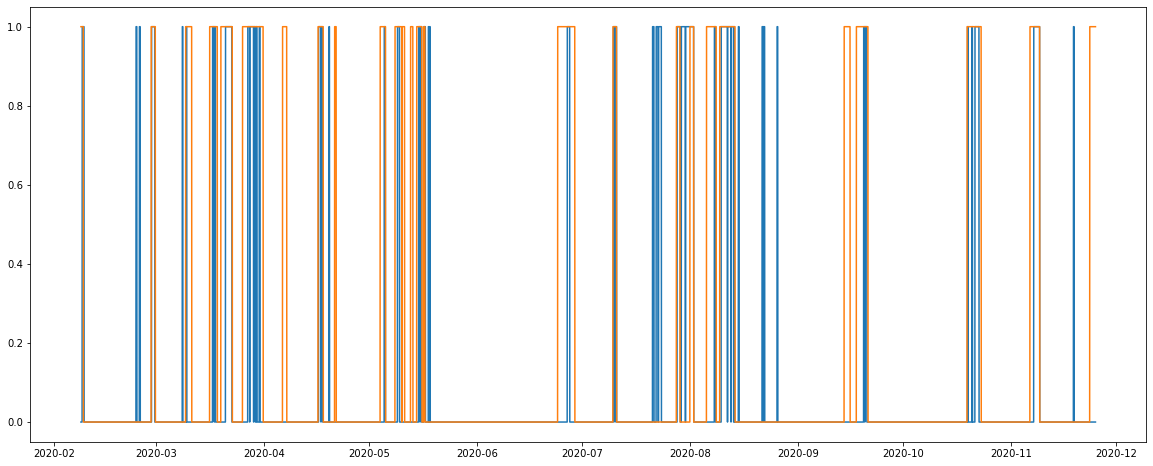

In [42]:
plt.figure(figsize = (20,8))
plt.plot(dataframe.index, dataframe_result_plot['D2_643358'])
plt.plot(df_new['DateTimeUTC'],df_new['sde_event'])

In [43]:
dataframe  = kmeans_class(df1, multivariate = True)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)

anomaly_kmean
TP                   14.00
FN                   12.00
TN                    8.00
FP                   17.00
accuracy              0.43
precision             0.45
recall                0.54
specificity           0.32
F1                    0.49

In [47]:
df1.columns[0:21]

Index(['BsB_S12', 'BsG_S12', 'BsR_S12', 'BbsB_S12', 'BbsG_S12', 'BbsR_S12',
       'BaCorr2_A13', 'BaCorr3_A13', 'BaCorr4_A13', 'BaCorr5_A13',
       'BaCorr6_A13', 'BaCorr7_A13', 'BaCorr1_A13', 'AAE', 'babs_450',
       'babs_550', 'babs_700', 'SSA_450', 'SSA_550', 'SSA_700', 'AE_SSA'],
      dtype='object')

In [48]:

dataframe  = kmeans_class(df1[df1.columns[0:21]], multivariate = False)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)


AE_SSA  BsR_S12  BsG_S12  BbsR_S12  BsB_S12    AAE  SSA_700  \
TP            13.00    20.00    19.00     19.00    18.00  13.00    11.00   
FN            13.00     6.00     7.00      7.00     8.00  13.00    15.00   
TN            14.00     6.00     6.00      6.00     6.00  11.00    13.00   
FP            11.00    19.00    19.00     19.00    19.00  14.00    12.00   
accuracy       0.53     0.51     0.49      0.49     0.47   0.47     0.47   
precision      0.54     0.51     0.50      0.50     0.49   0.48     0.48   
recall         0.50     0.77     0.73      0.73     0.69   0.50     0.42   
specificity    0.56     0.24     0.24      0.24     0.24   0.44     0.52   
F1             0.52     0.62     0.59      0.59     0.57   0.49     0.45   

             BbsB_S12  babs_450  BbsG_S12  ...  BaCorr4_A13  BaCorr5_A13  \
TP              18.00     18.00     17.00  ...        17.00        17.00   
FN               8.00      8.00      9.00  ...         9.00         9.00   
TN               5.00      4.00      5.00  ...         5.00         5.00   
FP              20.00     21.00     20.00  ...        20.00        20.00   
accuracy         0.45      0.43      0.43  ...         0.43         0.43   
precision        0.47      0.46      0.46  ...         0.46         0.46   
recall           0.69      0.69      0.65  ...         0.65         0.65   
specificity      0.20      0.16      0.20  ...         0.20         0.20   
F1               0.56      0.55      0.54  ...         0.54         0.54   

             BaCorr6_A13  BaCorr1_A13  babs_550  BaCorr3_A13  BaCorr7_A13  \
TP                 17.00        17.00     17.00        16.00        16.00   
FN                  9.00         9.00      9.00        10.00        10.00   
TN                  5.00         5.00      4.00         4.00         4.00   
FP                 20.00        20.00     21.00        21.00        21.00   
accuracy            0.43         0.43      0.41         0.39         0.39   
precision           0.46         0.46      0.45         0.43         0.43   
recall              0.65         0.65      0.65         0.62         0.62   
specificity         0.20         0.20      0.16         0.16         0.16   
F1                  0.54         0.54      0.53         0.51         0.51   

             babs_700  SSA_550  SSA_450  
TP              16.00    13.00     7.00  
FN              10.00    13.00    19.00  
TN               4.00     7.00    12.00  
FP              21.00    18.00    13.00  
accuracy         0.39     0.39     0.37  
precision        0.43     0.42     0.35  
recall           0.62     0.50     0.27  
specificity      0.16     0.28     0.48  
F1               0.51     0.46     0.30  

[9 rows x 21 columns]

In [49]:
dataframe_result.round( decimals =2).sort_values(by=['TP'], axis = 1,ascending=False)



BsR_S12  BbsR_S12  BsG_S12  BsB_S12  BbsB_S12  babs_450  \
TP             20.00     19.00    19.00    18.00     18.00     18.00   
FN              6.00      7.00     7.00     8.00      8.00      8.00   
TN              6.00      6.00     6.00     6.00      5.00      4.00   
FP             19.00     19.00    19.00    19.00     20.00     21.00   
accuracy        0.51      0.49     0.49     0.47      0.45      0.43   
precision       0.51      0.50     0.50     0.49      0.47      0.46   
recall          0.77      0.73     0.73     0.69      0.69      0.69   
specificity     0.24      0.24     0.24     0.24      0.20      0.16   
F1              0.62      0.59     0.59     0.57      0.56      0.55   

             BaCorr5_A13  babs_550  BaCorr1_A13  BaCorr6_A13  ...  \
TP                 17.00     17.00        17.00        17.00  ...   
FN                  9.00      9.00         9.00         9.00  ...   
TN                  5.00      4.00         5.00         5.00  ...   
FP                 20.00     21.00        20.00        20.00  ...   
accuracy            0.43      0.41         0.43         0.43  ...   
precision           0.46      0.45         0.46         0.46  ...   
recall              0.65      0.65         0.65         0.65  ...   
specificity         0.20      0.16         0.20         0.20  ...   
F1                  0.54      0.53         0.54         0.54  ...   

             BaCorr2_A13  BbsG_S12  BaCorr7_A13  BaCorr3_A13  babs_700    AAE  \
TP                 17.00     17.00        16.00        16.00     16.00  13.00   
FN                  9.00      9.00        10.00        10.00     10.00  13.00   
TN                  5.00      5.00         4.00         4.00      4.00  11.00   
FP                 20.00     20.00        21.00        21.00     21.00  14.00   
accuracy            0.43      0.43         0.39         0.39      0.39   0.47   
precision           0.46      0.46         0.43         0.43      0.43   0.48   
recall              0.65      0.65         0.62         0.62      0.62   0.50   
specificity         0.20      0.20         0.16         0.16      0.16   0.44   
F1                  0.54      0.54         0.51         0.51      0.51   0.49   

             SSA_550  AE_SSA  SSA_700  SSA_450  
TP             13.00   13.00    11.00     7.00  
FN             13.00   13.00    15.00    19.00  
TN              7.00   14.00    13.00    12.00  
FP             18.00   11.00    12.00    13.00  
accuracy        0.39    0.53     0.47     0.37  
precision       0.42    0.54     0.48     0.35  
recall          0.50    0.50     0.42     0.27  
specificity     0.28    0.56     0.52     0.48  
F1              0.46    0.52     0.45     0.30  

[9 rows x 21 columns]

In [50]:
dataframe_result['AE_neg']

KeyError: 'AE_neg'

In [ ]:
#dataframe_result[df1.columns[22:]]

In [37]:
dataframe = isolationforest_class(df1, multivariate = True)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)

anomaly_IF
TP                23.00
FN                 3.00
TN                 0.00
FP                25.00
accuracy           0.45
precision          0.48
recall             0.88
specificity        0.00
F1                 0.62

In [ ]:

dataframe = isolationforest_class(df1, multivariate = False)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)


In [ ]:
#dataframe_result[df1.columns[22:]]

In [38]:
dataframe = OCSVM_class(df1, multivariate = True)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)

anomaly_df
TP                18.00
FN                 8.00
TN                 3.00
FP                22.00
accuracy           0.41
precision          0.45
recall             0.69
specificity        0.12
F1                 0.55

In [ ]:
dataframe = OCSVM_class(df1, multivariate = False)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)


In [39]:
#dataframe_result[df1.columns[22:]]

In [40]:
dataframe = OCSVM_SGD_class(df1, multivariate = True)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)



anomaly_df
TP                 2.00
FN                24.00
TN                14.00
FP                11.00
accuracy           0.31
precision          0.15
recall             0.08
specificity        0.56
F1                 0.10

In [ ]:
'''dataframe = OCSVM_SGD_class(df1, multivariate = False)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)
'''

In [41]:
dataframe = LocalOutlierFactor_class(df1, multivariate = True)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)


anomaly_df
TP                13.00
FN                13.00
TN                 8.00
FP                17.00
accuracy           0.41
precision          0.43
recall             0.50
specificity        0.32
F1                 0.46

In [ ]:
dataframe = LocalOutlierFactor_class(df1, multivariate = False)
dataframe_result, dataframe_result_plot = classif_result(dataframe, df_SDE, SDE_events_start, SDE_events_end)
dataframe_result.round( decimals =2).sort_values(by=['accuracy','TP'], axis = 1,ascending=False)


In [ ]:
#dataframe_result[df1.columns[22:]]

# Test for different data sets:
# Test for multivariate = False

